In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from tabulate import tabulate
from multiprocessing import Pool
from scipy.ndimage import uniform_filter1d
import matplotlib.colors as mcolors
import tqdm.notebook as tqdm

# import the C++ module
sys.path.append('/home/hcleroy/PostDoc/aging_condensates/Simulation/Gillespie/System_backend')
import System_backend as backend
import Simulate_System as SimSys

sys.path.append('/home/hcleroy/PostDoc/aging_condensates/Simulation/super_simple_simulation/')

import Super_Simple_System as SSSys
import Super_Simple_Stochastic_Matrix as SSSMatrix


In [3]:
# define the unit of the system :
R = 50
L = 100
Eb = -10.
kdiff = 0.000207352
size = 100
dangling = True

In [5]:
Sys = backend.Gillespie(ell_tot=L,rho0=0.,BindingEnergy=Eb,kdiff=kdiff*5,seed = np.random.randint(0,1000000),Nlinker=3,dimension=1)

In [11]:
Sim = SimSys.Simulation(step_tot = 10**7,size=100,L_size=100,Gillespie = Sys)
Sim.simulate_eq_distribution()

In [15]:
np.max(Sim.R)

11.970331376603125

In [16]:
def make_2D_statistics(R,bins=100):
    #bins=100
    maxR = np.max(R)
    if R.shape[1] != 2 :
        print('The shape of the array does not match the function, expected (N,2) : 2 linkers ')
    def I(r):
        return int(r/maxR*(bins-1))
    X,Y = np.linspace(0,maxR,bins),np.linspace(0,maxR,bins)
    X,Y = np.meshgrid(X,Y)
    PR2D = np.zeros((bins,bins),dtype=float)
    for r in tqdm.tqdm(R):
        PR2D[I(r[0]),I(r[1])] += 1/R.shape[0]
    return X,Y,PR2D

In [17]:
#with Pool(10) as p:
#    res = p.map(make_2D_statistics,np.array([Sim.R[i*Sim.R.shape[0]//10:(i+1)*Sim.R.shape[0]//10] for i in range(10)]))
X,Y,Z = make_2D_statistics(Sim.R)

  0%|          | 0/10000000 [00:00<?, ?it/s]

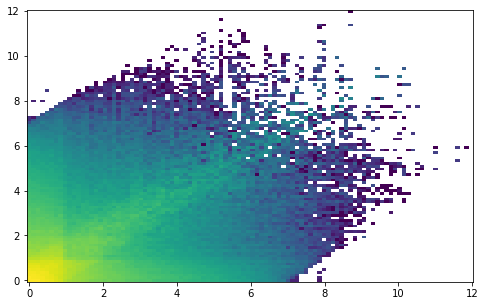

In [18]:
fig,ax = plt.subplots(figsize=(8,5))
ax.pcolormesh(X,Y,Z,norm=mcolors.LogNorm())
ax.set_xlabel('Position of the linker 1')
ax.set_ylabel('Position of the linker 2')